In [ ]:
# coding: utf-8
import torch
from tensorflow.keras import datasets
from torch.autograd import Variable
from torch import optim, nn
import numpy as np
import scipy.special
import scipy
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
import pandas as pd
from statistics import variance
from numpy.linalg import matrix_rank
from sklearn.decomposition import PCA
from collections import Counter
import gc
torch.set_printoptions(precision=16)

In [ ]:
# MLP class definition
class RHN:
# initialise MRHN

    def __init__(self, inputnodes=1, hiddennodes=1) :
        # set number of nodes in each input, hidden, output layer
        self.xnodes = inputnodes
        self.hnodes = hiddennodes

        # initialize the weight matrix as an orthnormal matrix
        self.w_xh = Variable(torch.tensor(scipy.linalg.orth(torch.randn(self.xnodes, self.hnodes, dtype=torch.float64))), \
                             requires_grad=True)

        self.loss_lst = []
        self.energy_lst = []

    def sat(self, x):
        x[x > 1] = 1
        x[x < -1] = -1
        return x

    def sign(self, x):
        x[x > 0] = 1
        x[x < 0] = -1
        return x

    def forward(self, x):
        h_output = torch.tanh(x @ self.w_xh)
        v_output = h_output @ self.w_xh.T

        return v_output

    def forward_no_act(self, x):
        return x @ self.w_xh @ self.w_xh.T

    def loss(self, y, y_pred):
        return torch.nn.functional.mse_loss(y, y_pred)


    def energy(self, x):
        h_output = x @ self.w_xh
        energy = -torch.linalg.norm(h_output @ h_output.T)

        return energy


    # this is Subspace Rotation Algorithm
    def subspace_train(self, inputs):

        stable = False

        inputs = torch.tensor(inputs, dtype=torch.float64)
        tmp_d = torch.ones((self.hnodes))
        self.w_xh = torch.tensor(scipy.linalg.orth(self.w_xh.detach().numpy()), dtype=torch.float64)
        while(stable==False):
            final_y =  self.w_xh @ self.w_xh.T @ inputs.T
            trans_mat = inputs.T @ torch.linalg.pinv(final_y)
            u, d, v = torch.linalg.svd(trans_mat)

            # determine whether we can break out the loop
            if torch.linalg.norm(tmp_d - d[0:self.hnodes]) < 1e-5:
                stable = True
                break
            else:
                tmp_d = d[0:self.hnodes]

            print("Indicator ", d[0: self.hnodes])
            self.w_xh = u @ v @ self.w_xh

        return self.w_xh

    # this is backpropagation through time training algorithm
    # if act=True, it is for the nonlinear RHN training
    def back_train(self, x, y, epoches, lr, act=True):

        self.w_xh.requires_grad = True

        lst = [self.w_xh]
        optimizer = torch.optim.Adam(lst, lr=lr)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)

        for epoch in range(epoches):
            optimizer.zero_grad()

            if act == True:
                y_pred = self.forward(x)
            else:
                y_pred = self.forward_no_act(x)

            loss_val = self.loss(y_pred, y)
            loss_val.backward(retain_graph=True)

            # keep tracking the loss value of the training process
            self.loss_lst.append(loss_val.detach().numpy())

            optimizer.step()
            scheduler.step()

            print("Progress ", epoch, loss_val)

        return self.loss_lst,

    # query the neural network forward
    # in the query function, it is easier
    # for us to transfer the tenor into numpy array
    def query(self, x, act=False, counter=500) :
        stable = False
        inputs = x
        w_xh = self.w_xh.detach().numpy()
        counter = 0
        while(stable == False):
            if act == True:
                final_inputs = np.tanh(inputs @ w_xh) @ w_xh.T
            else:
                final_inputs = inputs @ w_xh @ w_xh.T

            final_y = final_inputs

            err = inputs - final_y

            if np.linalg.norm(err) < 0.01 or counter==500:
                stable = True
                #print(counter)
            else:
                inputs = final_y
                counter += 1

        return self.sign(final_y)

In [ ]:
# Create the training patterns
a_pattern = np.array([[0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 1, 0, 0, 0],
                      [0, 0, 1, 0, 1, 0, 0],
                      [0, 1, 0, 0, 0, 1, 0],
                      [0, 1, 1, 1, 1, 1, 0],
                      [0, 1, 0, 0, 0, 1, 0],
                      [0, 1, 0, 0, 0, 1, 0],
                      [0, 1, 0, 0, 0, 1, 0],
                      [0, 0, 0, 0, 0, 0, 0]])

u_pattern = np.array([[0, 0, 0, 0, 0, 0, 0],
                      [0, 1, 0, 0, 0, 1, 0],
                      [0, 1, 0, 0, 0, 1, 0],
                      [0, 1, 0, 0, 0, 1, 0],
                      [0, 1, 0, 0, 0, 1, 0],
                      [0, 1, 0, 0, 0, 1, 0],
                      [0, 1, 0, 0, 0, 1, 0],
                      [0, 1, 1, 1, 1, 1, 0],
                      [0, 0, 0, 0, 0, 0, 0]])

t_pattern = np.array([[0, 0, 0, 0, 0, 0, 0],
                      [0, 1, 1, 1, 1, 1, 0],
                      [0, 0, 0, 1, 0, 0, 0],
                      [0, 0, 0, 1, 0, 0, 0],
                      [0, 0, 0, 1, 0, 0, 0],
                      [0, 0, 0, 1, 0, 0, 0],
                      [0, 0, 0, 1, 0, 0, 0],
                      [0, 0, 0, 1, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0]])

s_pattern = np.array([[0, 0, 0, 0, 0, 0, 0],
                      [0, 1, 1, 1, 1, 1, 0],
                      [0, 1, 0, 0, 0, 0, 0],
                      [0, 0, 1, 0, 0, 0, 0],
                      [0, 0, 0, 1, 0, 0, 0],
                      [0, 0, 0, 0, 1, 0, 0],
                      [0, 0, 0, 0, 0, 1, 0],
                      [0, 1, 1, 1, 1, 1, 0],
                      [0, 0, 0, 0, 0, 0, 0],])

In [ ]:
input_patterns = np.array([a_pattern.flatten(),
                           u_pattern.flatten(),
                           t_pattern.flatten(),
                           s_pattern.flatten()])

input_patterns = input_patterns * 2 - 1
input_patterns = torch.tensor(input_patterns, dtype=torch.float64)
print(input_patterns.shape)

torch.Size([4, 63])


In [ ]:
rhn = RHN(63, 4)

In [ ]:
subspace_train = True

if subspace_train == True:
    rhn.subspace_train(input_patterns)
else:
    loss_lst = rhn.back_train(input_patterns, input_patterns, 5000, 1e-4, act=False)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Indicator  tensor([186.7396431991421935,   4.1999455186776826,   3.3049838993787319,
          2.3478534186012885], dtype=torch.float64)
Indicator  tensor([1.0000000000000020, 1.0000000000000007, 1.0000000000000004,
        1.0000000000000000], dtype=torch.float64)


In [ ]:
# caculating the loss value for each patterns
loss_lst = []
input_patterns = torch.tensor(input_patterns, dtype=torch.float64)
for ix in range(4):
    pattern = rhn.forward_no_act(input_patterns[ix])
    loss = rhn.loss(input_patterns[ix], pattern)
    loss_lst.append(loss)

print(loss_lst)

[tensor(1.3036161238808536e-30, dtype=torch.float64), tensor(2.3493655133665451e-30, dtype=torch.float64), tensor(1.4413537422527763e-30, dtype=torch.float64), tensor(7.3662234825325132e-31, dtype=torch.float64)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


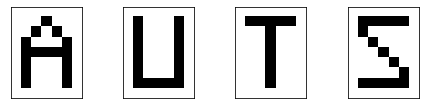

In [ ]:
plt.figure(figsize=(50,50))
counter = 1
for ix in range(4):
    plt.subplot(25,25,counter)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    res = rhn.query(input_patterns[ix], act=False)
    plt.imshow(res.reshape(9, 7), cmap=plt.cm.binary)
    counter = counter + 1
plt.show()

In [ ]:
# this is the program to search the sample space
# for calculating the radius of basin of attractions
patterns = input_patterns.detach().numpy()
dist_list = []
index = 0


for ia in range(0, 60):
    for ix in range(ia+1, 61):
        for iy in range(ix+1, 62):
            for iz in range(iy+1, 63):
                deviate_pattern = patterns[index].copy()
                deviate_pattern[ia]=deviate_pattern[ia]*(-1)
                deviate_pattern[ix]=deviate_pattern[ix]*(-1)
                deviate_pattern[iy]=deviate_pattern[iy]*(-1)
                deviate_pattern[iz]=deviate_pattern[iz]*(-1)
                res = rhn.query(deviate_pattern, act=False)
                dist = np.linalg.norm(res - patterns[index].copy(), ord=1)
                dist_list.append(dist)

print(Counter(dist_list))
print(len(dist_list))

Counter({0.0: 595665})
595665


in the following section, the MNIST dataset is used to test the capacity of the RHN model

In [ ]:
# loading the MNIST data set
# transfer the data into bipolar form
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images, test_images = (train_images / 255.0) * 2 - 1, (test_images / 255.0)*2 - 1

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
all_patterns = []
createIX = locals()
for ix in range(10):
    createIX['ina_' + str(ix)] = [i for i,a in enumerate(train_labels) if a==ix]
    createIX['a_patterns_' + str(ix)] = []


num_pat = 2
for ix in range(10):
    tmp_a = createIX['ina_' + str(ix)]
    pattern_a = []

    for iy in range(num_pat):
        pattern = train_images[tmp_a[iy]]
        pattern[pattern > 0] = 1
        pattern[pattern < 0] = -1
        pattern_a.append(pattern)
    createIX['a_patterns_' + str(ix)] = np.array(pattern_a)
    all_patterns.append(np.array(pattern_a))

In [ ]:
x_pat = np.array(all_patterns).reshape(20, 28, 28)

In [ ]:
patterns = np.array(all_patterns).reshape(20, 784)
input_patterns = torch.tensor(patterns, dtype=torch.float64)

In [ ]:
rhn = RHN(784, 20)

In [ ]:
subspace_train = True

if subspace_train == True:
    rhn.subspace_train(input_patterns)
else:
    loss_lst = rhn.back_train(input_patterns, input_patterns, 5000, 1e-4, act=False)

<ipython-input-2-72f3811924ed>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float64)


Indicator  tensor([285.5804315661187616,  77.0323920245224087,  29.7380575679439119,
         18.9553631117538544,  14.2557123205391640,  13.8973993415773425,
         10.5222364491576865,   9.8691653035381801,   9.0620300405863929,
          8.1991766623602462,   7.0420046041914901,   6.8906635796366471,
          6.0715627994105246,   5.2292476919707376,   5.0708455806253205,
          4.7322032644309706,   4.2826147563680248,   3.9448136700086009,
          3.7257926685652407,   3.2805872900328956], dtype=torch.float64)
Indicator  tensor([1.0000000000000111, 1.0000000000000009, 1.0000000000000009,
        1.0000000000000007, 1.0000000000000004, 1.0000000000000002,
        1.0000000000000000, 0.9999999999999999, 0.9999999999999999,
        0.9999999999999999, 0.9999999999999998, 0.9999999999999997,
        0.9999999999999996, 0.9999999999999991, 0.9999999999999991,
        0.9999999999999990, 0.9999999999999989, 0.9999999999999984,
        0.9999999999999981, 0.9999999999999881], dty

In [ ]:
def cover_patterns_1(pattern):
    pat = pattern.copy()
    for ix in range(0, 28, 2):
        for iy in range(0, 28, 2):
            pat[ix][iy] = 0

    return pat

def cover_patterns_2(pattern):
    pat = pattern.copy()
    pat = pat.reshape(784)
    for ix in range(0, 392):
            pat[ix] = 0

    return pat

def cover_patterns_3(pattern):
    pat = pattern.copy()
    pat = pat.reshape(784)
    for ix in range(392, 784):
            pat[ix] = 0

    return pat

def cover_patterns_4(pattern):
    pat = pattern.copy()
    pat = pat.reshape(28, 28)

    for ix in range(0, 28):
        for iy in range(0, 14):
            pat[ix][iy] = 0

    return pat

def cover_patterns_5(pattern):
    pat = pattern.copy()
    pat = pat.reshape(28, 28)

    for ix in range(0, 28):
        for iy in range(14, 28):
            pat[ix][iy] = 0

    return pat


In [ ]:
noise = np.random.normal(0, 0.6, 784)

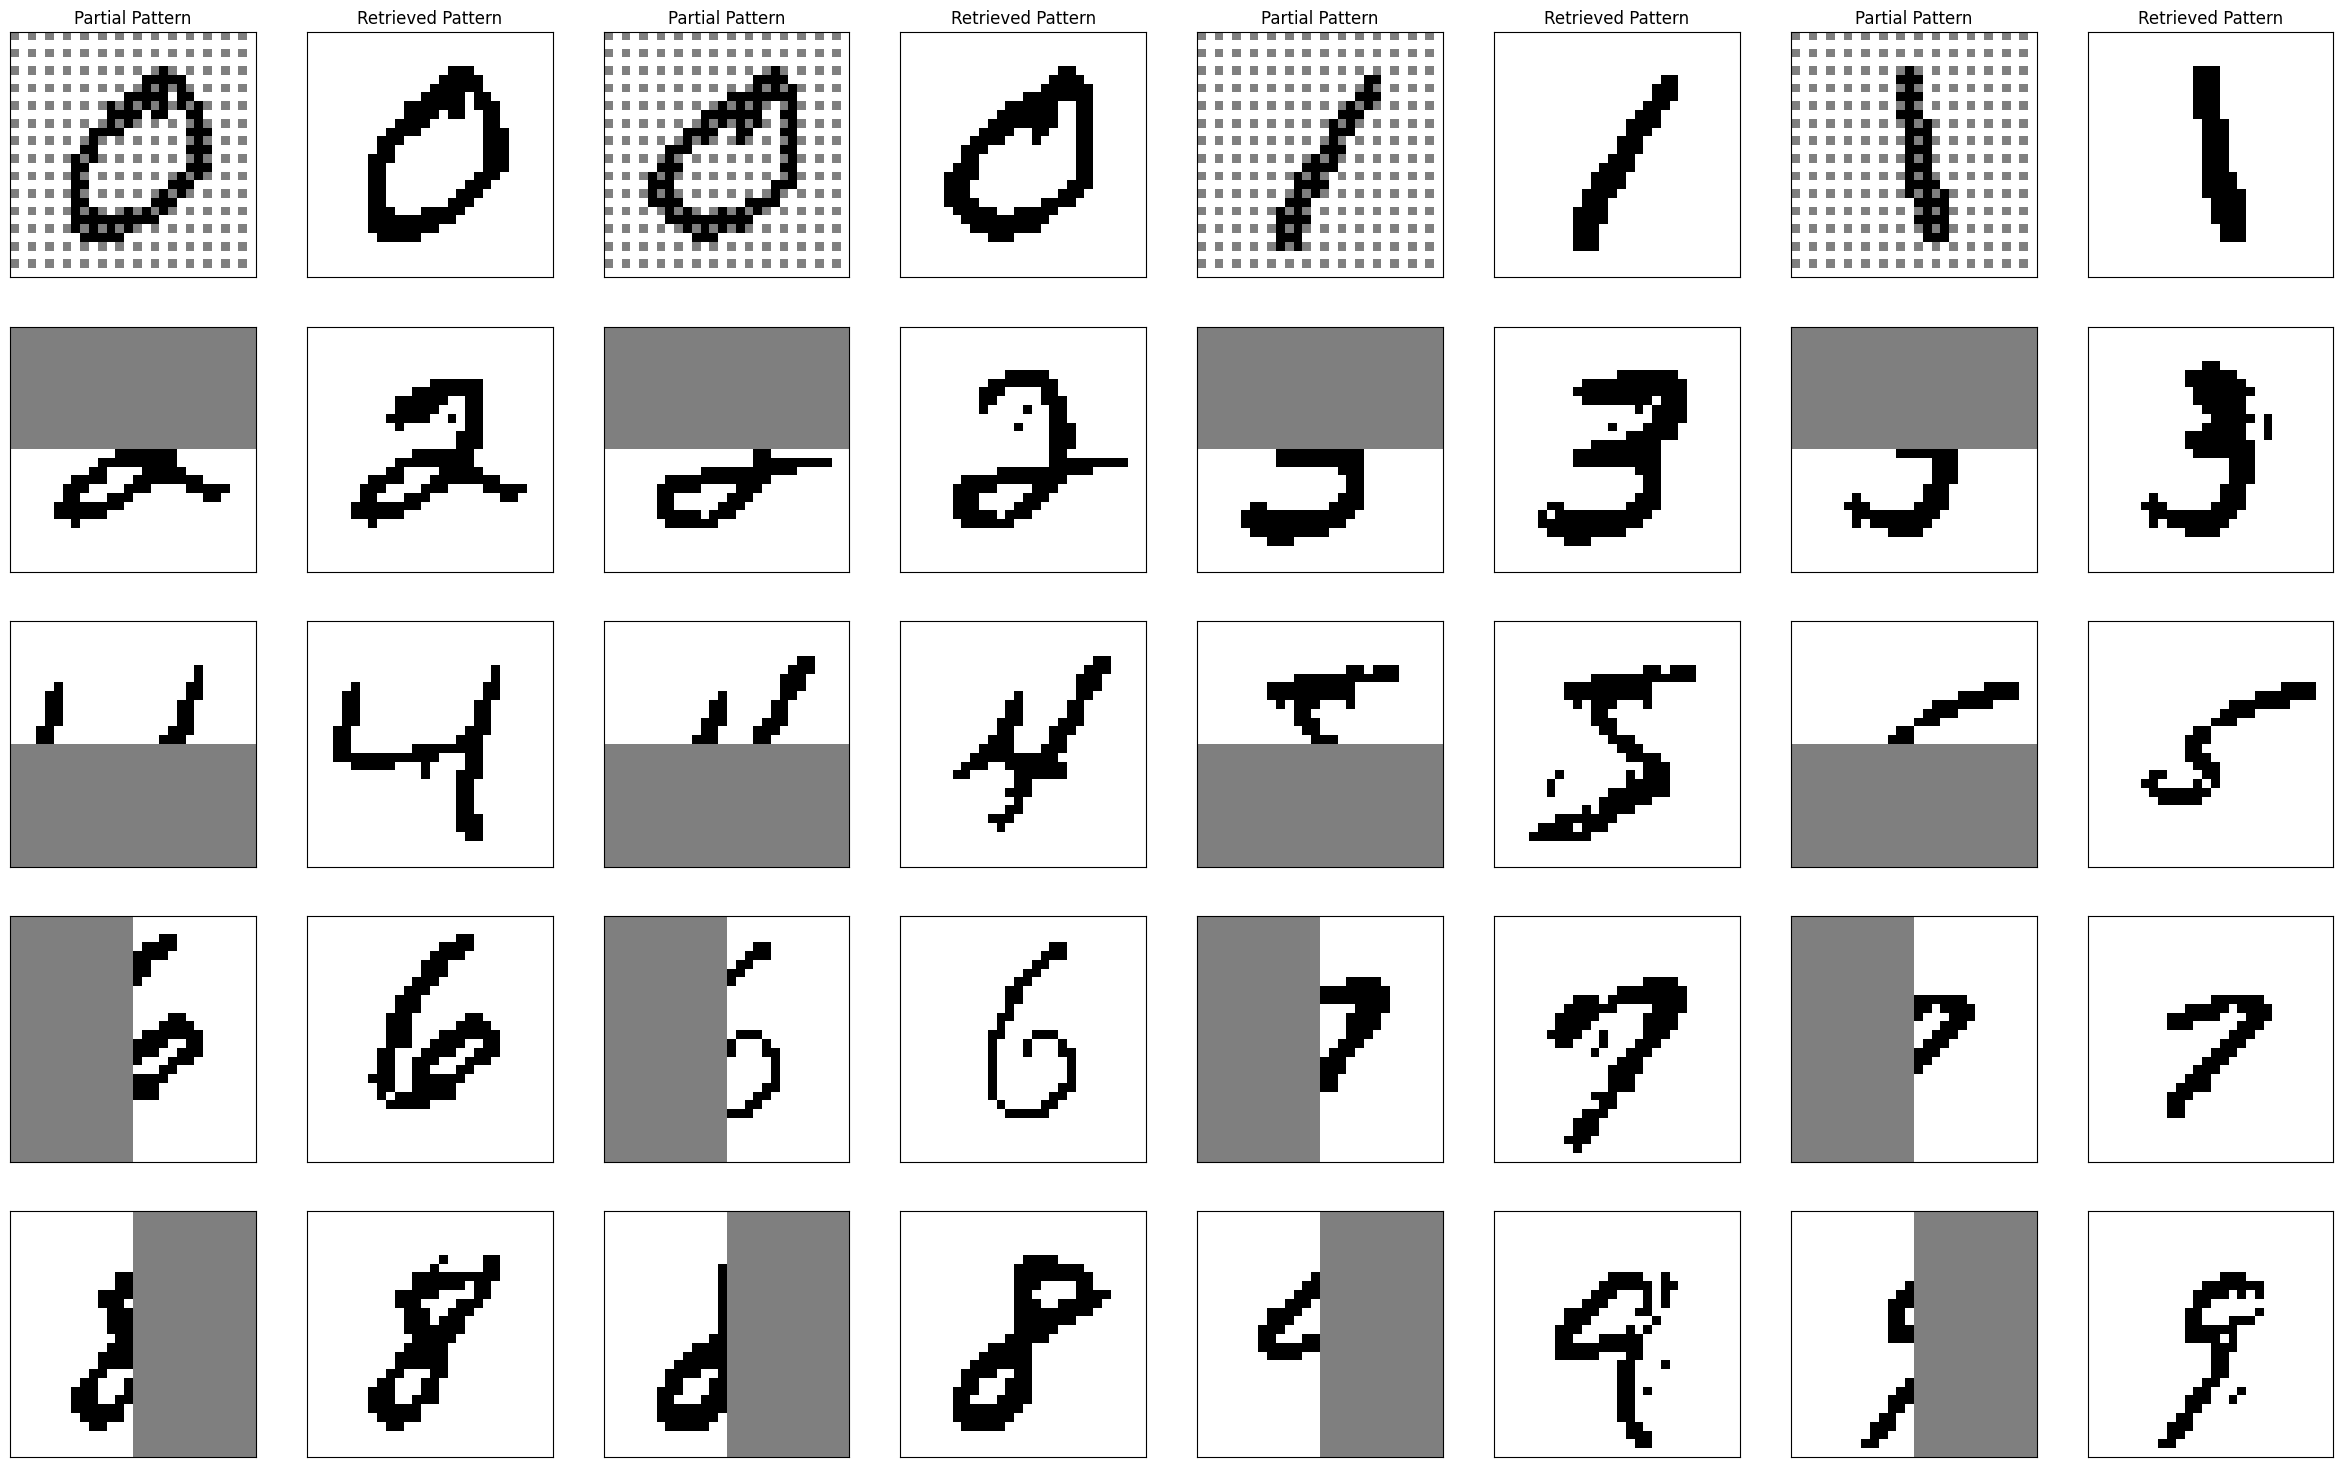

In [ ]:
plt.figure(figsize=(30, 30))
counter = 1
for iy in range(20):

    plt.subplot(8, 8,counter)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)


    if iy < 4:
        pat = cover_patterns_1(patterns[iy].reshape(28, 28))
        plt.title("Partial Pattern")

    if iy > 3 and iy < 8:
        pat = cover_patterns_2(patterns[iy].reshape(28, 28))

    if iy > 7 and iy < 12:
        pat = cover_patterns_3(patterns[iy].reshape(28, 28))

    if iy > 11 and iy < 16:
        pat = cover_patterns_4(patterns[iy].reshape(28, 28))

    if iy > 15 and iy < 20:
        pat = cover_patterns_5(patterns[iy].reshape(28, 28))

    plt.imshow(pat.reshape(28, 28), cmap=plt.cm.binary)
    counter = counter + 1

    plt.subplot(8, 8,counter)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    if iy < 4:
        pat = cover_patterns_1(patterns[iy].reshape(28, 28))
        res = rhn.query(pat.reshape(784), act=False)
        plt.title("Retrieved Pattern")

    if iy > 3 and iy < 8:
        pat = cover_patterns_2(patterns[iy].reshape(28, 28))
        res = rhn.query(pat.reshape(784), act=False)

    if iy > 7 and iy < 12:
        pat = cover_patterns_3(patterns[iy].reshape(28, 28))
        res = rhn.query(pat.reshape(784), act=False)

    if iy > 11 and iy < 16:
        pat = cover_patterns_4(patterns[iy].reshape(28, 28))
        res = rhn.query(pat.reshape(784), act=False)

    if iy > 15 and iy < 20:
        pat = cover_patterns_5(patterns[iy].reshape(28, 28))
        res = rhn.query(pat.reshape(784), act=False)

    plt.imshow(res.reshape(28, 28), cmap=plt.cm.binary)
    counter = counter + 1
plt.show()

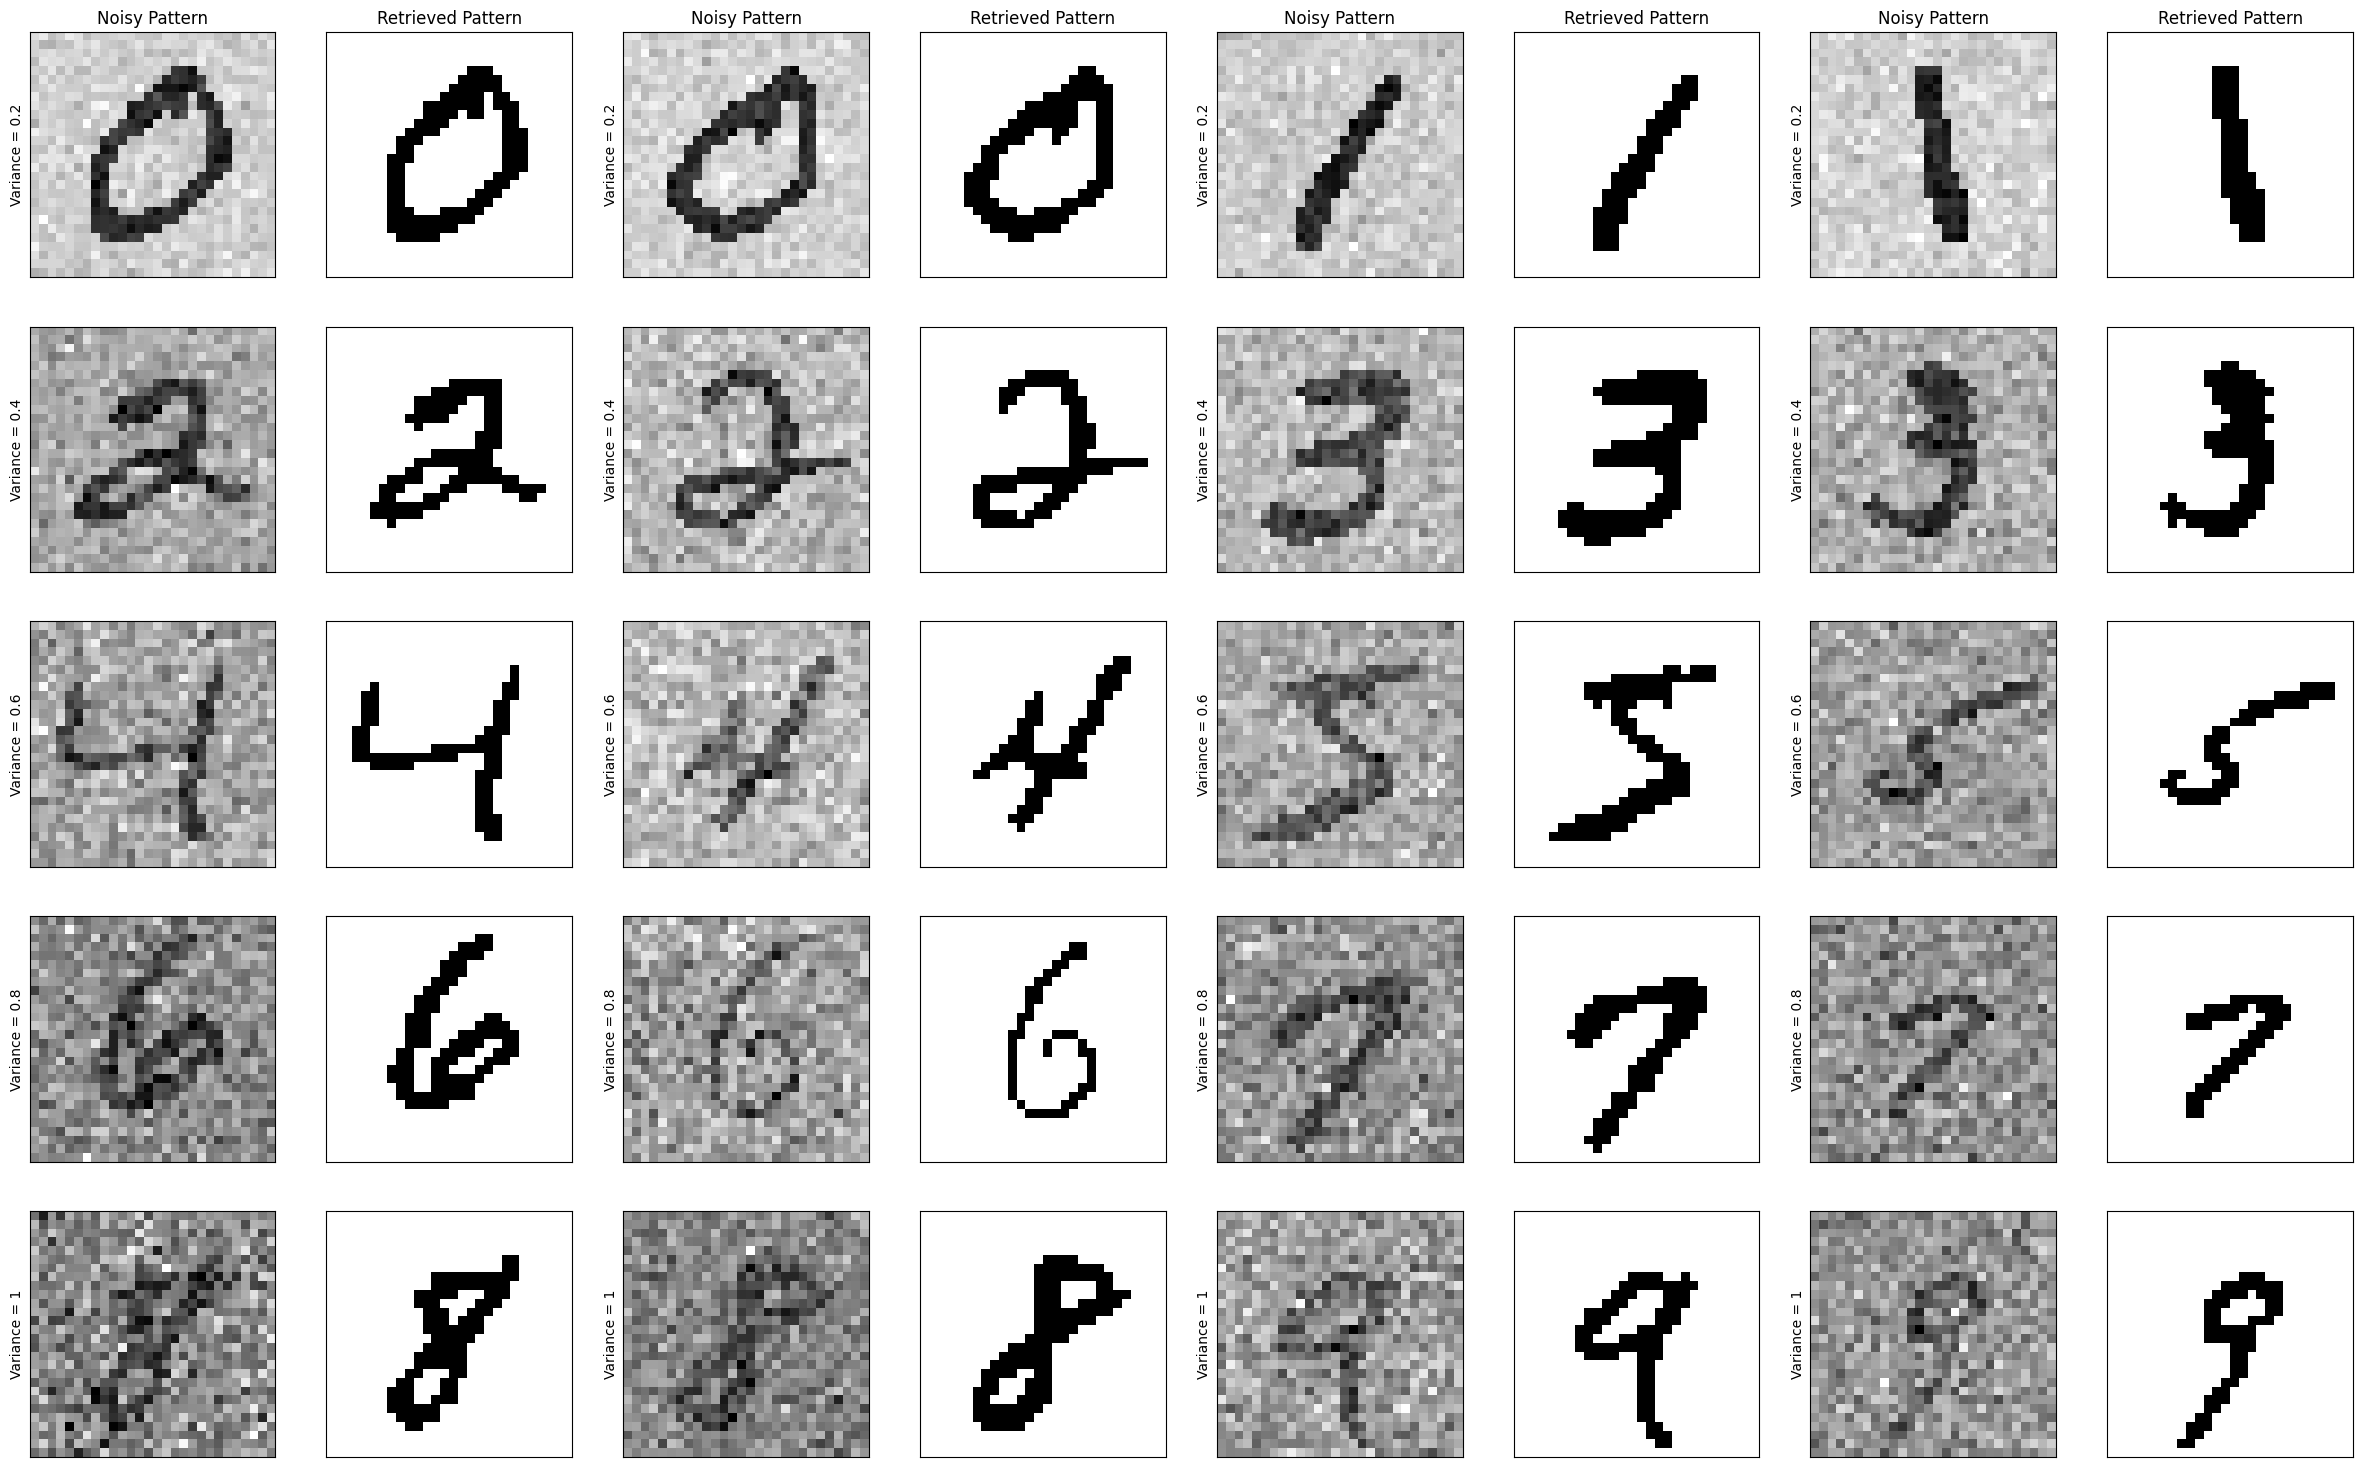

In [ ]:
plt.figure(figsize=(30, 30))
counter = 1
for iy in range(20):

    plt.subplot(8, 8,counter)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)


    if iy < 4:
        pat = patterns[iy].reshape(28, 28) + np.random.normal(0, 0.2, (28, 28))
        plt.title("Noisy Pattern")
        plt.ylabel("Variance = 0.2")

    if iy > 3 and iy < 8:
        pat = patterns[iy].reshape(28, 28) + np.random.normal(0, 0.4, (28, 28))
        plt.ylabel("Variance = 0.4")

    if iy > 7 and iy < 12:
        pat = patterns[iy].reshape(28, 28) + np.random.normal(0, 0.6, (28, 28))
        plt.ylabel("Variance = 0.6")

    if iy > 11 and iy < 16:
        pat = patterns[iy].reshape(28, 28) + np.random.normal(0, 0.8, (28, 28))
        plt.ylabel("Variance = 0.8")

    if iy > 15 and iy < 20:
        pat = patterns[iy].reshape(28, 28) + np.random.normal(0, 1, (28, 28))
        plt.ylabel("Variance = 1")

    plt.imshow(pat.reshape(28, 28), cmap=plt.cm.binary)
    counter = counter + 1

    plt.subplot(8, 8,counter)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    if iy < 4:
        res = rhn.query(pat.reshape(784), act=False)
        plt.title("Retrieved Pattern")

    if iy > 3 and iy < 8:
        res = rhn.query(pat.reshape(784), act=False)

    if iy > 7 and iy < 12:
        res = rhn.query(pat.reshape(784), act=False)

    if iy > 11 and iy < 16:
        res = rhn.query(pat.reshape(784), act=False)

    if iy > 15 and iy < 20:
        res = rhn.query(pat.reshape(784), act=False)

    plt.imshow(res.reshape(28, 28), cmap=plt.cm.binary)
    counter = counter + 1
plt.show()